In [3]:
import pandas as pd
import datefinder
from bs4 import BeautifulSoup
import wikifunctions as wf
import re
import numpy as np
from pathlib import Path
import glob
import matplotlib.pyplot as plt

to run `0_get_deletion_cases.py`, first we need to have the list of links to the logs where deletion cases are archived. for 2005-2025, this is formatted the same and you can run `recollect = True` on line 101 in order to make the file (which is stored as `log_links_YYYMMDD_TIME.tsv`).

Then when `recollect = False`, it will look at the specified log_links file, and go through and create a df of deletion cases for each YYYY-MM, in the folder `./deletion_cases`. 

For 2003 and 2004, the files are slightly more manually constructed in `0_get_deletion_cases_pre2005.ipynb`.

We should now have a folder full of monthly logs of deletion cases, with the following columns:

`log_link | case_title | case_discussion_url | multiple_noms | year | month | day`

This notebook now globs all of these files into one single df and deduplicates the cases.

# (old) getting deletion cases

In [ ]:
log_link_df = pd.read_csv("./../log_links_20250522_161526.tsv",sep='\t')
log_link_df

,year,month,day,log_link
0,2025,May,12,/wiki/Wikipedia:Articles_for_deletion/Log/2025...
1,2025,May,11,/wiki/Wikipedia:Articles_for_deletion/Log/2025...
2,2025,May,10,/wiki/Wikipedia:Articles_for_deletion/Log/2025...
3,2025,May,9,/wiki/Wikipedia:Articles_for_deletion/Log/2025...
4,2025,May,8,/wiki/Wikipedia:Articles_for_deletion/Log/2025...
...,...,...,...,...
6702,2007,January,5,/wiki/Wikipedia:Articles_for_deletion/Log/2007...
6703,2007,January,4,/wiki/Wikipedia:Articles_for_deletion/Log/2007...
6704,2007,January,3,/wiki/Wikipedia:Articles_for_deletion/Log/2007...
6705,2007,January,2,/wiki/Wikipedia:Articles_for_deletion/Log/2007...


In [3]:
log_link_df['log_link'].tolist()[10][6:]

'Wikipedia:Articles_for_deletion/Log/2025_May_2'

In [4]:
wf.get_page_raw_content(link[10][6:])

NameError: name 'link' is not defined

In [3]:
soup = BeautifulSoup( wf.get_page_raw_content("Wikipedia:Articles_for_deletion/Log/2025_April_27") , features="html.parser")

# get all the deletion cases
# block > boilerplate afd vfd xfd-closed archived
cases = soup.find_all("div", class_=lambda classes: classes and 'boilerplate' in classes and 'afd' in classes and 'xfd-closed' in classes)

In [4]:
len(cases)

63

In [41]:
c = cases[29]

In [42]:
case_title = c.find("div", class_="mw-heading mw-heading3").get_text()
case_title

'United Nations Flight 052P'

In [43]:
case_discussion_url = f"Wikipedia:Articles_for_deletion/{case_title}"
case_discussion_url

'Wikipedia:Articles_for_deletion/United Nations Flight 052P'

In [44]:
c.find(string=lambda text: text and "AfDs for this article:" in text)

# globbing deletion_cases into one nice, clean, dedup file

In [4]:
uncleaned_cases = Path.cwd().parent / "deletion_cases"
# f"deletion_cases_{i}_{n}_uncleaned.tsv"
files = list(uncleaned_cases.glob("deletion_cases_*_*_uncleaned.tsv"))
print(len(files))

269


In [5]:
row_counts = [max(0, pd.read_csv(f, sep="\t").shape[0]) for f in files]
average_rows = sum(row_counts) / len(row_counts) if row_counts else 0
print(f"Average number of rows (excluding header): {average_rows}")

median_rows = np.median(row_counts)
print(f"Median number of rows (excluding header): {median_rows}")
print(f"Smallest number of rows (excluding header): {np.min(row_counts)}")
print(f"Biggest number of rows (excluding header): {np.max(row_counts)}")

Average number of rows (excluding header): 1992.828996282528
Median number of rows (excluding header): 1886.0
Smallest number of rows (excluding header): 0
Biggest number of rows (excluding header): 5450


In [4]:
np.std(row_counts)

np.float64(982.90386505113)

In [5]:
1993 * 269

536117

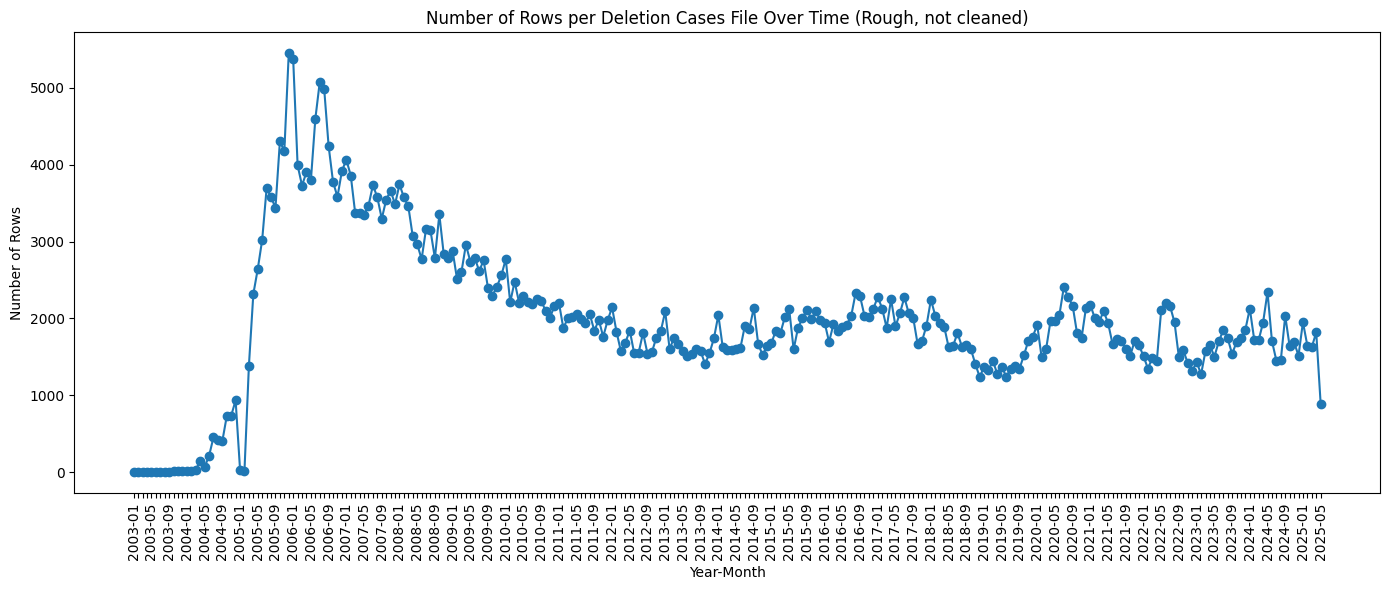

In [6]:
# Extract year and month from each filename and count rows
file_info = []
for f in files:
    # Example filename: deletion_cases_2021_04_uncleaned.tsv
    match = re.search(r'deletion_cases_(\d{4})_(\d{2})_.*uncleaned\.tsv', f.name)
    if match:
        year = int(match.group(1))
        month = int(match.group(2))
        row_count = max(0, pd.read_csv(f, sep="\t").shape[0])
        file_info.append((year, month, row_count))

# Sort by year and month
file_info.sort(key=lambda x: (x[0], x[1]))

# Prepare data for plotting
labels = [f"{year}-{month:02d}" for year, month, _ in file_info]
row_counts = [row_count for _, _, row_count in file_info]

plt.figure(figsize=(14, 6))
plt.plot(labels, row_counts, marker='o')

# Only label every 4th tick on the x-axis
tick_labels = [label if i % 4 == 0 else "" for i, label in enumerate(labels)]
plt.xticks(ticks=range(len(labels)), labels=tick_labels, rotation=90)

plt.xlabel('Year-Month')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per Deletion Cases File Over Time (Rough, not cleaned)')
plt.tight_layout()
plt.show()

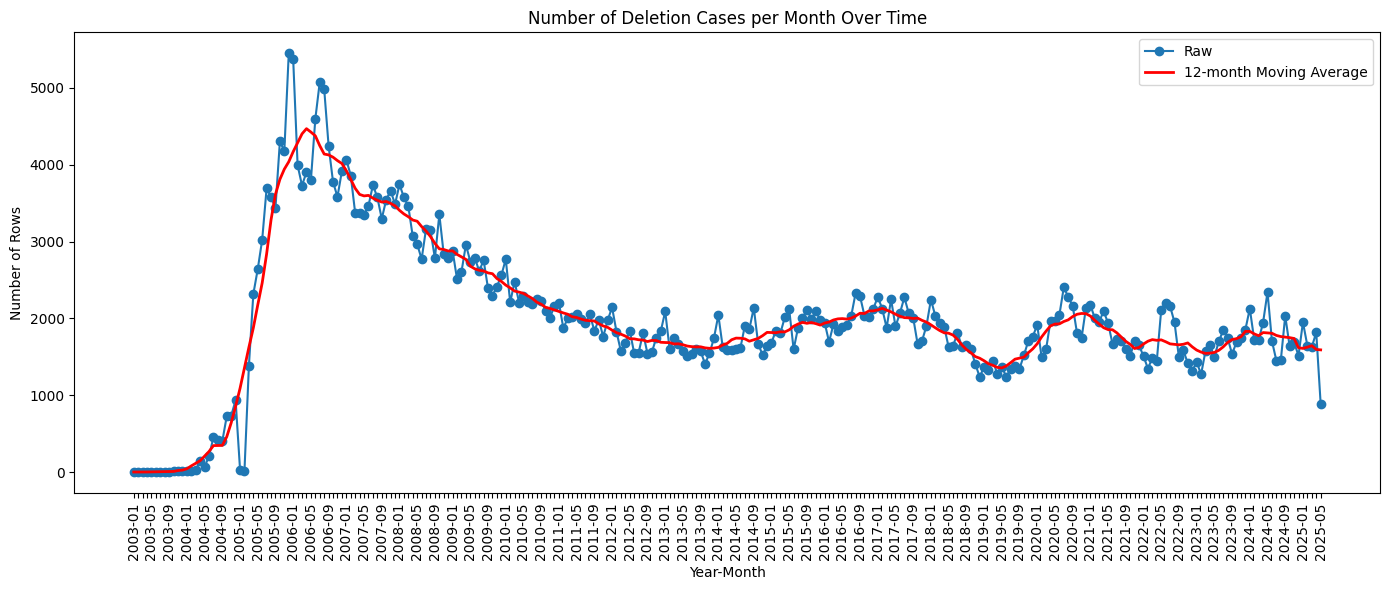

In [7]:
window_size = 12  # You can adjust the window size for smoothing
row_counts_smooth = pd.Series(row_counts).rolling(window=window_size, center=True, min_periods=1).mean()

plt.figure(figsize=(14, 6))
plt.plot(labels, row_counts, marker='o', label='Raw')
plt.plot(labels, row_counts_smooth, color='red', linewidth=2, label=f'{window_size}-month Moving Average')

tick_labels = [label if i % 4 == 0 else "" for i, label in enumerate(labels)]
plt.xticks(ticks=range(len(labels)), labels=tick_labels, rotation=90)

plt.xlabel('Year-Month')
plt.ylabel('Number of Rows')
plt.title('Number of Deletion Cases per Month Over Time')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
dfs = [pd.read_csv(f, sep="\t") for f in files]
df_combined = pd.concat(dfs, ignore_index=True)

In [10]:
len(df_combined)

536071

In [11]:
df_combined[~df_combined['case_title'].isna()]

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day
0,Wikipedia:Archived_articles_for_deletion_discu...,Wikicide,Wikipedia:Articles_for_deletion/Wikicide,False,2003,6,28
1,Wikipedia:Archived_articles_for_deletion_discu...,Reciprocal_System_of_Theory,Wikipedia:Votes_for_deletion/Reciprocal_System...,False,2004,8,31
2,Wikipedia:Archived_articles_for_deletion_discu...,List_of_heterosexuals,Wikipedia:Articles_for_deletion/List_of_hetero...,False,2003,8,31
3,Wikipedia:Archived_articles_for_deletion_discu...,Md._Ahiduzzaman_Liton,Wikipedia:Articles_for_deletion/Md._Ahiduzzama...,False,2003,9,9
4,Wikipedia:Archived_articles_for_deletion_discu...,Misconceptions_and_disputed_facts,Wikipedia:Articles_for_deletion/Misconceptions...,False,2003,9,20
...,...,...,...,...,...,...,...
536066,/wiki/Wikipedia:Articles_for_deletion/Log/2025...,The Flying Wedge Award,Wikipedia:Articles_for_deletion/The Flying Wed...,False,2025,May,1
536067,/wiki/Wikipedia:Articles_for_deletion/Log/2025...,-ington,Wikipedia:Articles_for_deletion/-ington,False,2025,May,1
536068,/wiki/Wikipedia:Articles_for_deletion/Log/2025...,HighPoint,Wikipedia:Articles_for_deletion/HighPoint,False,2025,May,1
536069,/wiki/Wikipedia:Articles_for_deletion/Log/2025...,Prajal Regmi,Wikipedia:Articles_for_deletion/Prajal Regmi,False,2025,May,1


In [12]:
na_rows = df_combined[df_combined['case_title'].isna()]
if not na_rows.empty:
    first_log_link = na_rows.iloc[0]['log_link']
    print("First log_link with NA case_title:", first_log_link)

First log_link with NA case_title: /wiki/Wikipedia:Articles_for_deletion/Log/2005_January_3


In [13]:
len(na_rows)

932

See line 80 in `0_get_deletion_cases.py`

In [13]:
df_combined = df_combined.dropna(subset=['case_title'])
len(df_combined)

535139

uncomment the below cell if you are meaning to re-create the full df, uncleaned

In [14]:
#df_combined.to_csv("deletion_cases_uncleaned_combined.tsv", sep="\t", index=False, header=True)

In [19]:
# note - the 900 or so na cases have been dropped here already
df_combined = pd.read_csv("deletion_cases_uncleaned_combined.tsv", sep="\t", header=0)

In [24]:
# taking a look at cases with "nomination"
df_combined[df_combined["case_title"].str.contains(r"\(.* nomination\)", regex=True, na=False)]

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
55,Wikipedia:Archived_articles_for_deletion_discu...,Atlantium (1st nomination),Wikipedia:Votes for deletion/Atlantium (1st no...,True,2004,2,8,Atlantium
500,Wikipedia:Archived_articles_for_deletion_discu...,Nick Berg conspiracy theories (1st nomination),Wikipedia:Articles for deletion/Nick Berg cons...,True,2004,6,29,Nick Berg conspiracy theories
2136,Wikipedia:Archived_articles_for_deletion_discu...,Matthew Richardson (2nd nomination),Wikipedia:Articles for deletion/Matthew Richar...,True,2004,10,17,Matthew Richardson
15986,/wiki/Wikipedia:Articles_for_deletion/Log/2005...,Paul Sharp (2nd nomination),Wikipedia:Articles_for_deletion/Paul Sharp (2n...,True,2005,July,12,Paul Sharp
23149,/wiki/Wikipedia:Articles_for_deletion/Log/2005...,Zip cube (second nomination),Wikipedia:Articles_for_deletion/Zip cube (seco...,True,2005,September,11,Zip cube
...,...,...,...,...,...,...,...,...
452785,/wiki/Wikipedia:Articles_for_deletion/Log/2021...,Northwest Post-Grunge (2nd nomination),Wikipedia:Articles_for_deletion/Northwest Post...,True,2021,April,2,Northwest Post-Grunge
461683,/wiki/Wikipedia:Articles_for_deletion/Log/2021...,List of presidents/prime ministers/chancellors...,Wikipedia:Articles_for_deletion/List of presid...,True,2021,October,27,List of presidents/prime ministers/chancellors...
463134,/wiki/Wikipedia:Articles_for_deletion/Log/2021...,Mrbrown (2nd nomination),Wikipedia:Articles_for_deletion/Mrbrown (2nd n...,True,2021,November,28,Mrbrown
463736,/wiki/Wikipedia:Articles_for_deletion/Log/2021...,List of presidents/prime ministers by longevit...,Wikipedia:Articles_for_deletion/List of presid...,True,2021,November,18,List of presidents/prime ministers by longevity


In [20]:
# update multiple noms column
df_combined['multiple_noms'] = df_combined['multiple_noms'] | df_combined['case_title'].str.contains(r"\(.* nomination\)", regex=True, na=False)

In [21]:
# create case title cleaned (aka, what we expect the regular article page title to be)
df_combined['case_title_cleaned'] = df_combined['case_title'].str.replace(r"\(.* nomination\)", "", regex=True).str.strip()
df_combined['case_title_cleaned'] = df_combined['case_title_cleaned'].str.replace("_", " ").str.strip()

In [ ]:
df_combined

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
0,Wikipedia:Archived_articles_for_deletion_discu...,Wikicide,Wikipedia:Articles_for_deletion/Wikicide,False,2003,6,28,Wikicide
1,Wikipedia:Archived_articles_for_deletion_discu...,Reciprocal_System_of_Theory,Wikipedia:Votes_for_deletion/Reciprocal_System...,False,2004,8,31,Reciprocal System of Theory
2,Wikipedia:Archived_articles_for_deletion_discu...,List_of_heterosexuals,Wikipedia:Articles_for_deletion/List_of_hetero...,False,2003,8,31,List of heterosexuals
3,Wikipedia:Archived_articles_for_deletion_discu...,Md._Ahiduzzaman_Liton,Wikipedia:Articles_for_deletion/Md._Ahiduzzama...,False,2003,9,9,Md. Ahiduzzaman Liton
4,Wikipedia:Archived_articles_for_deletion_discu...,Misconceptions_and_disputed_facts,Wikipedia:Articles_for_deletion/Misconceptions...,False,2003,9,20,Misconceptions and disputed facts
...,...,...,...,...,...,...,...,...
535134,/wiki/Wikipedia:Articles_for_deletion/Log/2025...,The Flying Wedge Award,Wikipedia:Articles_for_deletion/The Flying Wed...,False,2025,May,1,The Flying Wedge Award
535135,/wiki/Wikipedia:Articles_for_deletion/Log/2025...,-ington,Wikipedia:Articles_for_deletion/-ington,False,2025,May,1,-ington
535136,/wiki/Wikipedia:Articles_for_deletion/Log/2025...,HighPoint,Wikipedia:Articles_for_deletion/HighPoint,False,2025,May,1,HighPoint
535137,/wiki/Wikipedia:Articles_for_deletion/Log/2025...,Prajal Regmi,Wikipedia:Articles_for_deletion/Prajal Regmi,False,2025,May,1,Prajal Regmi


In [23]:
df_combined[df_combined['case_title'] == "Leader of the Opposition (Japan)"]

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
462799,/wiki/Wikipedia:Articles_for_deletion/Log/2021...,Leader of the Opposition (Japan),Wikipedia:Articles_for_deletion/Leader of the ...,False,2021,October,5,Leader of the Opposition (Japan)
535138,/wiki/Wikipedia:Articles_for_deletion/Log/2025...,Leader of the Opposition (Japan),Wikipedia:Articles_for_deletion/Leader of the ...,True,2025,May,1,Leader of the Opposition (Japan)


In [25]:
df_combined[df_combined["case_title"].str.contains(r"Anthony Fok", regex=True)]

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
469463,/wiki/Wikipedia:Articles_for_deletion/Log/2022...,Anthony Fok,Wikipedia:Articles_for_deletion/Anthony Fok,False,2022,March,26,Anthony Fok
477951,/wiki/Wikipedia:Articles_for_deletion/Log/2022...,Anthony Fok,Wikipedia:Articles_for_deletion/Anthony Fok,True,2022,July,10,Anthony Fok
482329,/wiki/Wikipedia:Articles_for_deletion/Log/2022...,Anthony Fok (3rd nomination),Wikipedia:Articles_for_deletion/Anthony Fok (3...,True,2022,October,25,Anthony Fok


In [26]:
df_combined[df_combined["case_title"].str.contains(r"Hollie Steel", regex=True)]

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
177451,/wiki/Wikipedia:Articles_for_deletion/Log/2009...,Hollie Steel,Wikipedia:Articles_for_deletion/Hollie Steel,False,2009,April,26,Hollie Steel
180017,/wiki/Wikipedia:Articles_for_deletion/Log/2009...,Hollie Steel,Wikipedia:Articles_for_deletion/Hollie Steel,True,2009,May,31,Hollie Steel
180544,/wiki/Wikipedia:Articles_for_deletion/Log/2009...,Hollie Steel (2nd nomination),Wikipedia:Articles_for_deletion/Hollie Steel (...,True,2009,May,26,Hollie Steel


In [27]:
# updating multiple_noms value based on whether case_title_cleaned has duplicates
dup_mask = df_combined['case_title_cleaned'].duplicated(keep=False)
df_combined['multiple_noms'] = df_combined['multiple_noms'] | dup_mask

In [53]:
# checking with Hollie Steel example
df_combined[df_combined["case_title"].str.contains(r"Ted Ankrum", regex=True)]

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
131478,/wiki/Wikipedia:Articles_for_deletion/Log/2008...,Ted Ankrum,Wikipedia:Articles_for_deletion/Ted Ankrum,False,2008,01,31,Ted Ankrum


In [29]:
# making the df that has multiple nominations based on the multiple_noms OR fact that there are duplicates in case_title_cleaned
duplicates_df = df_combined[
    (df_combined['multiple_noms']) |
    (df_combined['case_title_cleaned'].duplicated(keep=False))
]

In [30]:
duplicates_df.sort_values(by="case_title_cleaned")

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
178697,/wiki/Wikipedia:Articles_for_deletion/Log/2009...,!!!Fuck You!!!,Wikipedia:Articles_for_deletion/!!!Fuck You!!!,True,2009,April,14,!!!Fuck You!!!
76115,/wiki/Wikipedia:Articles_for_deletion/Log/2006...,!!!Fuck You!!!,Wikipedia:Articles_for_deletion/!!!Fuck You!!!,True,2006,September,9,!!!Fuck You!!!
182564,/wiki/Wikipedia:Articles_for_deletion/Log/2009...,"""-cides""","Wikipedia:Articles_for_deletion/""-cides""",True,2009,May,2,"""-cides"""
32623,/wiki/Wikipedia:Articles_for_deletion/Log/2005...,"""55 STITCHES""","Wikipedia:Articles_for_deletion/""55 STITCHES""",True,2005,November,1,"""55 STITCHES"""
32624,/wiki/Wikipedia:Articles_for_deletion/Log/2005...,"""55 STITCHES""","Wikipedia:Articles_for_deletion/""55 STITCHES""",True,2005,November,1,"""55 STITCHES"""
...,...,...,...,...,...,...,...,...
501423,/wiki/Wikipedia:Articles_for_deletion/Log/2023...,山州,Wikipedia:Articles_for_deletion/山州,True,2023,October,17,山州
502889,/wiki/Wikipedia:Articles_for_deletion/Log/2023...,山州,Wikipedia:Articles_for_deletion/山州,True,2023,November,21,山州
130396,/wiki/Wikipedia:Articles_for_deletion/Log/2007...,東北大學,Wikipedia:Articles_for_deletion/東北大學,True,2007,December,9,東北大學
125001,/wiki/Wikipedia:Articles_for_deletion/Log/2007...,東北大學,Wikipedia:Articles_for_deletion/東北大學,True,2007,November,25,東北大學


In [31]:
print("Total rows in df_combined:", len(df_combined))
print("Rows in duplicates_df:", len(duplicates_df))

Total rows in df_combined: 535139
Rows in duplicates_df: 70514


In [32]:
len(df_combined) - len(duplicates_df)

464625

In [33]:
len(df_combined.drop(duplicates_df.index))

464625

In [ ]:
# Map month names to numbers if necessary
month_map = {
    'January': '01', 'February': '02', 'March': '03', 'April': '04',
    'May': '05', 'June': '06', 'July': '07', 'August': '08',
    'September': '09', 'October': '10', 'November': '11', 'December': '12',

    '1': '01', '2': '02', '3': '03', '4': '04',
    '5': '05', '6': '06', '7': '07', '8': '08',
    '9': '09', 

    1: '01', 2: '02', 3: '03', 4: '04',
    5: '05', 6: '06', 7: '07', 8: '08',
    9: '09', 10: '10', 11: '11', 12: '12'
}

df_combined['month'] = df_combined['month'].replace(month_map)
df_combined['year'] = df_combined['year'].astype(str)

In [ ]:
# exporting the version where the months / years are consistent in system
#df_combined.to_csv("deletion_cases_uncleaned_combined.tsv", sep="\t", index=False, header=True)

In [ ]:
monthly_df = df_combined.groupby(['year', 'month']).size().reset_index(name='count')

In [73]:
monthly_df[(monthly_df['year'] == '2004') | (monthly_df['year'] == '2005')].sort_values(by=["year", "month"])

,year,month,count
8,2004,01,9
9,2004,02,10
10,2004,03,30
11,2004,04,142
12,2004,05,65
13,2004,06,207
14,2004,07,451
15,2004,08,413
16,2004,09,402
17,2004,10,725


In [62]:
df_combined.groupby(['year', 'month']).size().reset_index(name='count').sort_values(by=["year", "month"])

,year,month,count
0,2002,03,1
1,2002,12,1
2,2003,06,1
3,2003,08,2
4,2003,09,3
...,...,...,...
260,2025,01,1949
261,2025,02,1644
262,2025,03,1625
263,2025,04,1816


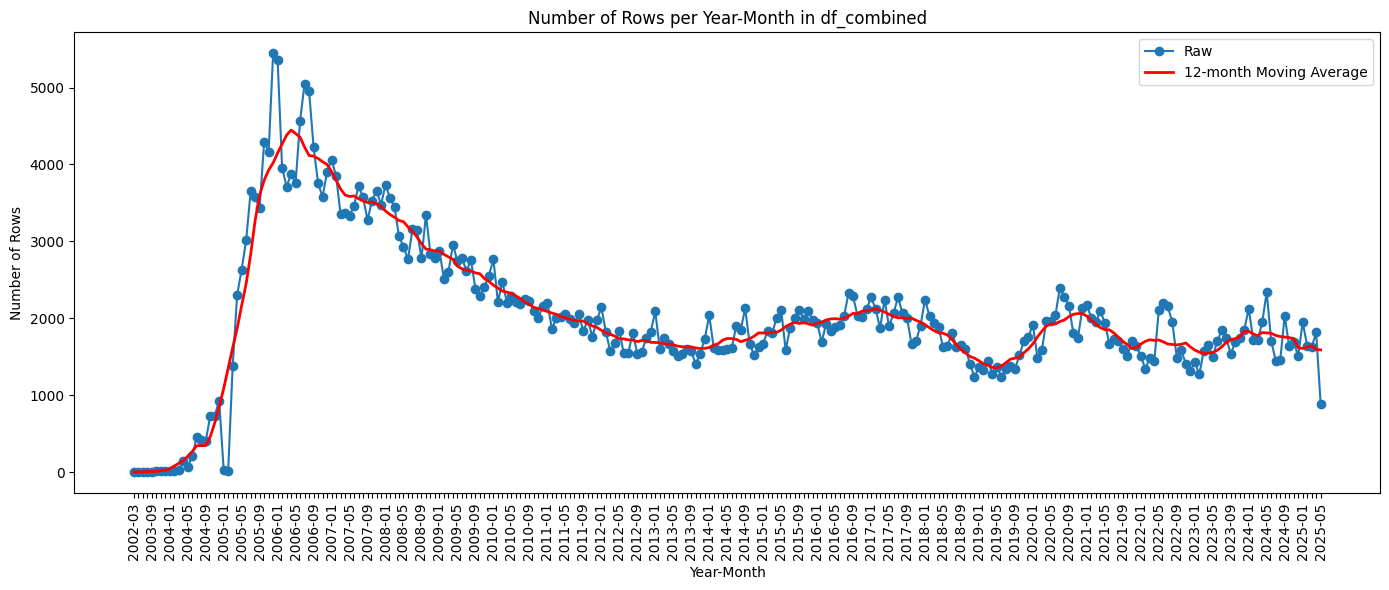

In [64]:
# Group by year and month, count number of rows per group
group_counts = df_combined.groupby(['year', 'month']).size().reset_index(name='count').sort_values(by=["year", "month"])

# Create a 'year-month' label for x-axis
group_counts['year_month'] = group_counts['year'].astype(str) + '-' + group_counts['month'].astype(str).str.zfill(2)

# Calculate 12-month moving average
group_counts['moving_avg'] = group_counts['count'].rolling(window=12, center=True, min_periods=1).mean()

plt.figure(figsize=(14, 6))
plt.plot(group_counts['year_month'], group_counts['count'], marker='o', label='Raw')
plt.plot(group_counts['year_month'], group_counts['moving_avg'], color='red', linewidth=2, label='12-month Moving Average')
plt.xlabel('Year-Month')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per Year-Month in df_combined')
plt.xticks(
    ticks=range(len(group_counts['year_month'])),
    labels=[label if i % 4 == 0 else "" for i, label in enumerate(group_counts['year_month'])],
    rotation=90
)
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
_dropped = df_combined.drop(duplicates_df.index)
_dropped[_dropped["case_title"].str.contains(r"Ted Ankrum", regex=True)]

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
131478,/wiki/Wikipedia:Articles_for_deletion/Log/2008...,Ted Ankrum,Wikipedia:Articles_for_deletion/Ted Ankrum,False,2008,01,31,Ted Ankrum


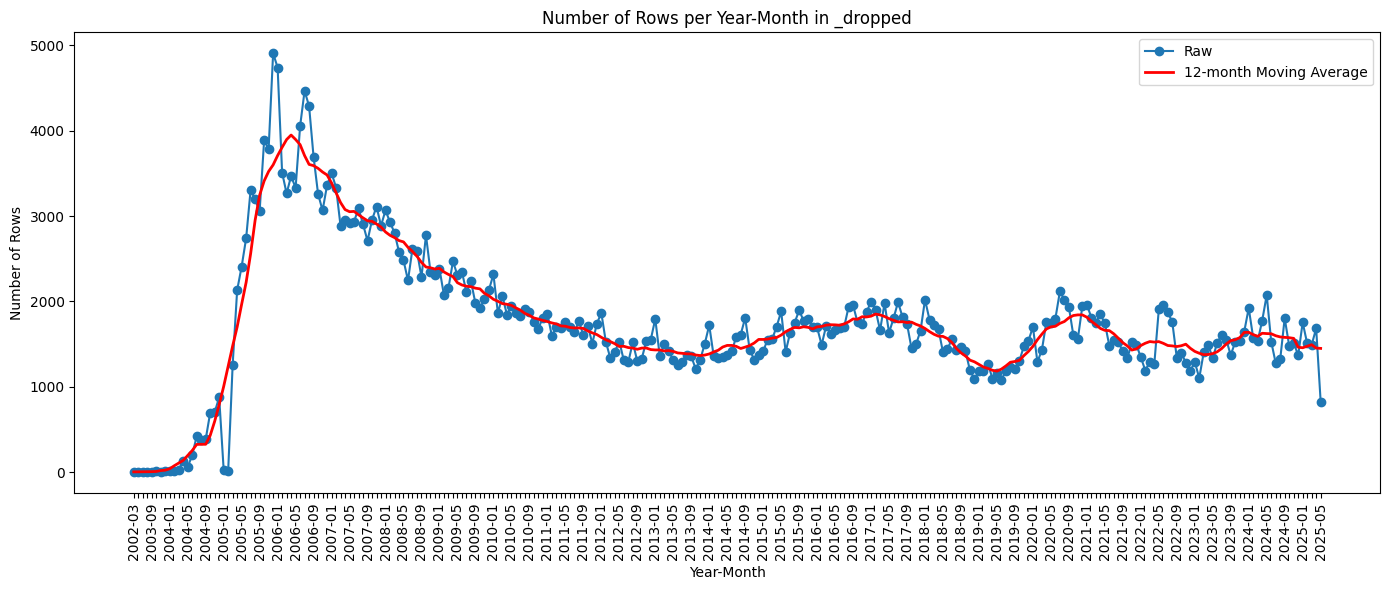

In [69]:
# Group by year and month, count number of rows per group
group_counts_dropped = _dropped.groupby(['year', 'month']).size().reset_index(name='count').sort_values(by=["year", "month"])

# Create a 'year-month' label for x-axis
group_counts_dropped['year_month'] = group_counts_dropped['year'].astype(str) + '-' + group_counts_dropped['month'].astype(str).str.zfill(2)

# Calculate 12-month moving average
group_counts_dropped['moving_avg'] = group_counts_dropped['count'].rolling(window=12, center=True, min_periods=1).mean()

plt.figure(figsize=(14, 6))
plt.plot(group_counts_dropped['year_month'], group_counts_dropped['count'], marker='o', label='Raw')
plt.plot(group_counts_dropped['year_month'], group_counts_dropped['moving_avg'], color='red', linewidth=2, label='12-month Moving Average')
plt.xlabel('Year-Month')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per Year-Month in _dropped')
plt.xticks(
    ticks=range(len(group_counts_dropped['year_month'])),
    labels=[label if i % 4 == 0 else "" for i, label in enumerate(group_counts_dropped['year_month'])],
    rotation=90
)
plt.legend()
plt.tight_layout()
plt.show()

In [70]:
group_counts_dropped[(group_counts_dropped['year'] == '2004') | (group_counts_dropped['year'] == '2005')]

,year,month,count,year_month,moving_avg
8,2004,01,9,2004-01,39.416667
9,2004,02,8,2004-02,74.333333
10,2004,03,30,2004-03,105.750000
11,2004,04,133,2004-04,137.500000
12,2004,05,60,2004-05,194.666667
13,2004,06,198,2004-06,252.500000
14,2004,07,420,2004-07,324.500000
15,2004,08,379,2004-08,326.083333
16,2004,09,384,2004-09,326.333333
17,2004,10,695,2004-10,428.750000


In [75]:
dedup_df = df_combined.drop(duplicates_df.index)

In [76]:
dedup_df.sort_values(by="case_title_cleaned")

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
58762,/wiki/Wikipedia:Articles_for_deletion/Log/2006...,! Records,Wikipedia:Articles_for_deletion/! Records,False,2006,05,1,! Records
18211,/wiki/Wikipedia:Articles_for_deletion/Log/2005...,!! 6- -.4rtist.com,Wikipedia:Articles_for_deletion/!! 6- -.4rtist...,False,2005,08,23,!! 6- -.4rtist.com
428120,/wiki/Wikipedia:Articles_for_deletion/Log/2020...,!!!!!!!,Wikipedia:Articles_for_deletion/!!!!!!!,False,2020,05,31,!!!!!!!
70035,/wiki/Wikipedia:Articles_for_deletion/Log/2006...,!!M,Wikipedia:Articles_for_deletion/!!M,False,2006,08,22,!!M
122608,/wiki/Wikipedia:Articles_for_deletion/Log/2007...,!Hero (album),Wikipedia:Articles_for_deletion/!Hero (album),False,2007,10,16,!Hero (album)
...,...,...,...,...,...,...,...,...
332486,/wiki/Wikipedia:Articles_for_deletion/Log/2015...,야성의 동맹,Wikipedia:Articles_for_deletion/야성의 동맹,False,2015,11,10,야성의 동맹
408806,/wiki/Wikipedia:Articles_for_deletion/Log/2019...,지마 (X1-MA),Wikipedia:Articles_for_deletion/지마 (X1-MA),False,2019,04,17,지마 (X1-MA)
16055,/wiki/Wikipedia:Articles_for_deletion/Log/2005...,,Wikipedia:Articles_for_deletion/,False,2005,07,11,
500844,/wiki/Wikipedia:Articles_for_deletion/Log/2023...,𝼛,Wikipedia:Articles_for_deletion/𝼛,False,2023,10,27,𝼛


In [77]:
# previously was named deletion_cases_uncleaned_dedup
dedup_df.to_csv("deletion_cases_dedup.tsv", sep="\t", index=False, header=True)

In [95]:
len(dedup_df)

464625

In [ ]:
dedup_df['year'] = dedup_df['year'].astype(int)
dedup_df['year']

In [79]:
dedup_time = dedup_df[dedup_df['year'].astype(int).between(2007, 2024)]
len(dedup_time)

378202

In [80]:
dedup_time.to_csv("deletion_cases_dedup_2007_2024_1.tsv", sep="\t", index=False, header=True)

In [81]:
dedup_time = pd.read_csv("deletion_cases_dedup_2007_2024_1.tsv", sep="\t", header=0)
dedup_time

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
0,Wikipedia:Archived_articles_for_deletion_discu...,List_of_interesting_or_unusual_place_names/200...,Wikipedia:Articles_for_deletion/List_of_intere...,False,2008,11,11,List of interesting or unusual place names/200...
1,Wikipedia:Archived_articles_for_deletion_discu...,AKFD,Wikipedia:Articles_for_deletion/AKFD,False,2024,12,2,AKFD
2,Wikipedia:Archived_articles_for_deletion_discu...,Talk:Customer experience management,Talk:Customer experience management,False,2008,6,25,Talk:Customer experience management
3,Wikipedia:Archived_articles_for_deletion_discu...,Pleasant Valley School District,Wikipedia:Votes for deletion/Pleasant Valley S...,False,2015,7,22,Pleasant Valley School District
4,Wikipedia:Archived_articles_for_deletion_discu...,Predicted effects of invading Iraq/2004 Nomina...,Wikipedia:Articles for deletion/Predicted effe...,False,2008,10,25,Predicted effects of invading Iraq/2004 Nomina...
...,...,...,...,...,...,...,...,...
378197,/wiki/Wikipedia:Articles_for_deletion/Log/2024...,Nerdy Prudes Must Die,Wikipedia:Articles_for_deletion/Nerdy Prudes M...,False,2024,12,1,Nerdy Prudes Must Die
378198,/wiki/Wikipedia:Articles_for_deletion/Log/2024...,List of serving generals of the People's Repub...,Wikipedia:Articles_for_deletion/List of servin...,False,2024,12,1,List of serving generals of the People's Repub...
378199,/wiki/Wikipedia:Articles_for_deletion/Log/2024...,List of Johns Hopkins University student organ...,Wikipedia:Articles_for_deletion/List of Johns ...,False,2024,12,1,List of Johns Hopkins University student organ...
378200,/wiki/Wikipedia:Articles_for_deletion/Log/2024...,Nissrine Chaoudri,Wikipedia:Articles_for_deletion/Nissrine Chaoudri,False,2024,12,1,Nissrine Chaoudri


In [82]:
# Group by year and month, count items per group
group_counts = dedup_time.groupby(['year', 'month']).size()

mean_count = group_counts.mean()
median_count = group_counts.median()
min_count = group_counts.min()
max_count = group_counts.max()
std = group_counts.std()

print(f"Mean: {mean_count}")
print(f"Median: {median_count}")
print(f"Min: {min_count}")
print(f"Max: {max_count}")
print(f"Std: {std}")

Mean: 1750.9351851851852
Median: 1669.5
Min: 1084
Max: 3506
Std: 469.77965687336706


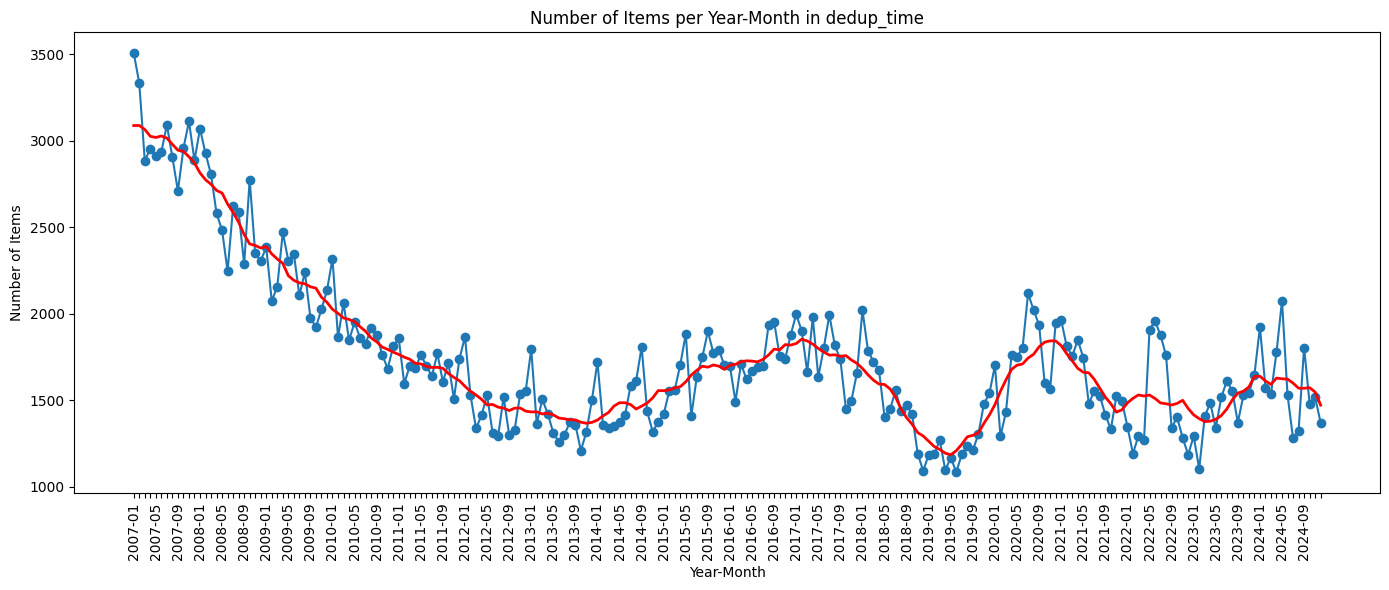

In [86]:
# Group by year and month, count items per group
items_per_month = dedup_time.groupby(['year', 'month']).size().reset_index(name='count')

# Create a 'year-month' label for x-axis
items_per_month['year_month'] = items_per_month['year'].astype(str) + '-' + items_per_month['month'].astype(str).str.zfill(2)

# Calculate 12-month moving average
items_per_month['moving_avg'] = items_per_month['count'].rolling(window=12, center=True, min_periods=1).mean()

plt.figure(figsize=(14, 6))
plt.plot(items_per_month['year_month'], items_per_month['count'], marker='o', label='Raw')
plt.plot(items_per_month['year_month'], items_per_month['moving_avg'], color='red', linewidth=2, label='12-month Moving Average')

labels = items_per_month['year_month'].tolist()
tick_labels = [label if i % 4 == 0 else "" for i, label in enumerate(labels)]
plt.xticks(ticks=range(len(labels)), labels=tick_labels, rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Number of Items')
plt.title('Number of Items per Year-Month in dedup_time')
plt.tight_layout()
plt.show()

In [87]:
wf.get_page_raw_content("신현규")

''

In [88]:
wf.get_page_raw_content('BTS')

'<div class="mw-content-ltr mw-parser-output" lang="en" dir="ltr"><div class="shortdescription nomobile noexcerpt noprint searchaux" style="display:none">South Korean boy band</div>\n<style data-mw-deduplicate="TemplateStyles:r1236090951">.mw-parser-output .hatnote{font-style:italic}.mw-parser-output div.hatnote{padding-left:1.6em;margin-bottom:0.5em}.mw-parser-output .hatnote i{font-style:normal}.mw-parser-output .hatnote+link+.hatnote{margin-top:-0.5em}@media print{body.ns-0 .mw-parser-output .hatnote{display:none!important}}</style><div role="note" class="hatnote navigation-not-searchable">For other uses, see <a href="/wiki/BTS_(disambiguation)" class="mw-disambig" title="BTS (disambiguation)">BTS (disambiguation)</a>.</div>\n<p class="mw-empty-elt">\n\n\n\n</p>\n<style data-mw-deduplicate="TemplateStyles:r1126788409">.mw-parser-output .plainlist ol,.mw-parser-output .plainlist ul{line-height:inherit;list-style:none;margin:0;padding:0}.mw-parser-output .plainlist ol li,.mw-parser-ou

In [89]:
wf.get_page_raw_content("!!!!!!!")

'<div class="mw-content-ltr mw-parser-output" lang="en" dir="ltr"><div class="shortdescription nomobile noexcerpt noprint searchaux" style="display:none">2019 studio album by Billie Eilish</div>\n<style data-mw-deduplicate="TemplateStyles:r1236090951">.mw-parser-output .hatnote{font-style:italic}.mw-parser-output div.hatnote{padding-left:1.6em;margin-bottom:0.5em}.mw-parser-output .hatnote i{font-style:normal}.mw-parser-output .hatnote+link+.hatnote{margin-top:-0.5em}@media print{body.ns-0 .mw-parser-output .hatnote{display:none!important}}</style><div role="note" class="hatnote navigation-not-searchable">For the concerts, see <a href="/wiki/When_We_All_Fall_Asleep_Tour" title="When We All Fall Asleep Tour">When We All Fall Asleep Tour</a> and <a href="/wiki/Where_Do_We_Go%3F_World_Tour" title="Where Do We Go? World Tour">Where Do We Go? World Tour</a>.</div>\n<p class="mw-empty-elt">\n\n</p>\n<style data-mw-deduplicate="TemplateStyles:r1129693374">.mw-parser-output .hlist dl,.mw-parse

In [90]:
wf.get_redirects_map(["!!!!!!!","신현규","BTS","WP:NPOV"])

{'Wikipedia:NPOV': 'Wikipedia:Neutral point of view',
 '!!!!!!!': 'When We All Fall Asleep, Where Do We Go?'}

In [94]:
dedup_time

,log_link,case_title,case_discussion_url,multiple_noms,year,month,day,case_title_cleaned
0,Wikipedia:Archived_articles_for_deletion_discu...,List_of_interesting_or_unusual_place_names/200...,Wikipedia:Articles_for_deletion/List_of_intere...,False,2008,11,11,List of interesting or unusual place names/200...
1,Wikipedia:Archived_articles_for_deletion_discu...,AKFD,Wikipedia:Articles_for_deletion/AKFD,False,2024,12,2,AKFD
2,Wikipedia:Archived_articles_for_deletion_discu...,Talk:Customer experience management,Talk:Customer experience management,False,2008,6,25,Talk:Customer experience management
3,Wikipedia:Archived_articles_for_deletion_discu...,Pleasant Valley School District,Wikipedia:Votes for deletion/Pleasant Valley S...,False,2015,7,22,Pleasant Valley School District
4,Wikipedia:Archived_articles_for_deletion_discu...,Predicted effects of invading Iraq/2004 Nomina...,Wikipedia:Articles for deletion/Predicted effe...,False,2008,10,25,Predicted effects of invading Iraq/2004 Nomina...
...,...,...,...,...,...,...,...,...
378197,/wiki/Wikipedia:Articles_for_deletion/Log/2024...,Nerdy Prudes Must Die,Wikipedia:Articles_for_deletion/Nerdy Prudes M...,False,2024,12,1,Nerdy Prudes Must Die
378198,/wiki/Wikipedia:Articles_for_deletion/Log/2024...,List of serving generals of the People's Repub...,Wikipedia:Articles_for_deletion/List of servin...,False,2024,12,1,List of serving generals of the People's Repub...
378199,/wiki/Wikipedia:Articles_for_deletion/Log/2024...,List of Johns Hopkins University student organ...,Wikipedia:Articles_for_deletion/List of Johns ...,False,2024,12,1,List of Johns Hopkins University student organ...
378200,/wiki/Wikipedia:Articles_for_deletion/Log/2024...,Nissrine Chaoudri,Wikipedia:Articles_for_deletion/Nissrine Chaoudri,False,2024,12,1,Nissrine Chaoudri


Ought to run `1_get_case_content.py` to check if `page_exists` and collect the content of the discussion

In [93]:
df_existing_now = pd.read_csv("deletion_cases_discussions_existing_now_TEST.tsv", sep="\t")
df_existing_now.head()

,case_title_cleaned,page_exists,case_discussion_url,case_discussion_raw_HTML
0,Dynamic painting,True,Wikipedia:Articles_for_deletion/Dynamic painting,"<div class=""mw-content-ltr mw-parser-output"" l..."
1,Amanda Rishworth,True,Wikipedia:Articles_for_deletion/Amanda Rishworth,"<div class=""mw-content-ltr mw-parser-output"" l..."
2,Walter Oi,True,Wikipedia:Articles_for_deletion/Walter Oi,"<div class=""mw-content-ltr mw-parser-output"" l..."
3,Steve Higgins,True,Wikipedia:Articles_for_deletion/Steve Higgins,"<div class=""mw-content-ltr mw-parser-output"" l..."
4,Chloe Dao,True,Wikipedia:Articles_for_deletion/Chloe Dao,"<div class=""mw-content-ltr mw-parser-output"" l..."
